In [6]:
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from nbafuns import *
import seaborn.objects as snso
from sklearn.metrics.pairwise import pairwise_distances_argmin

data_DIR = "../data/synergy/"

In [4]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [7]:
year = 2024
df = pd.read_parquet(data_DIR +f"NBA_Synergy_Team_PG_{year}.parquet")
df.columns = map(str.lower, df.columns)

In [9]:
df.columns

Index(['season_id', 'team_id', 'team_abbreviation', 'team_name', 'play_type',
       'type_grouping', 'percentile', 'gp', 'poss_pct', 'ppp', 'fg_pct',
       'ft_poss_pct', 'tov_poss_pct', 'sf_poss_pct', 'plusone_poss_pct',
       'score_poss_pct', 'efg_pct', 'poss', 'pts', 'fgm', 'fga', 'fgmx'],
      dtype='object')

In [10]:
df1 = df.query("type_grouping == 'Offensive'")
df1 = df1[["team_name","play_type","poss_pct"]]
df1 = df1.sort_values(by=["team_name","play_type"])
df1 = df1.fillna(0)
dfs = df1.pivot_table(index= "team_name", columns= "play_type", values= "poss_pct", aggfunc= "mean")
dfs = dfs.fillna(0)
dfs = dfs.drop(columns= ["Misc"])
dfs = dfs[['PRBallHandler','Isolation','Spotup','OffScreen','Handoff','Cut','PRRollMan','Postup','OffRebound',"Transition"]]

In [12]:
features = dfs.to_numpy()
scaled_features = features

# Finding Optimal Number of Clusters

In [13]:
kmeans_kwargs = {"init": "random", "n_init": 10,"random_state": 42}

 # A list holds the SSE values for each k
sse = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

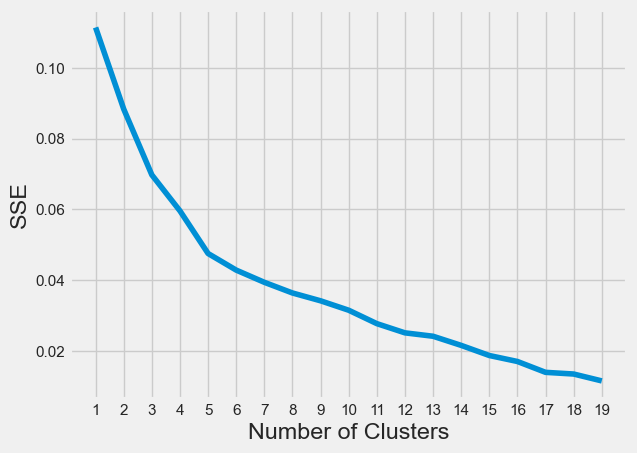

In [14]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 20), sse)
plt.xticks(range(1, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [15]:
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_coefficients.append(score)

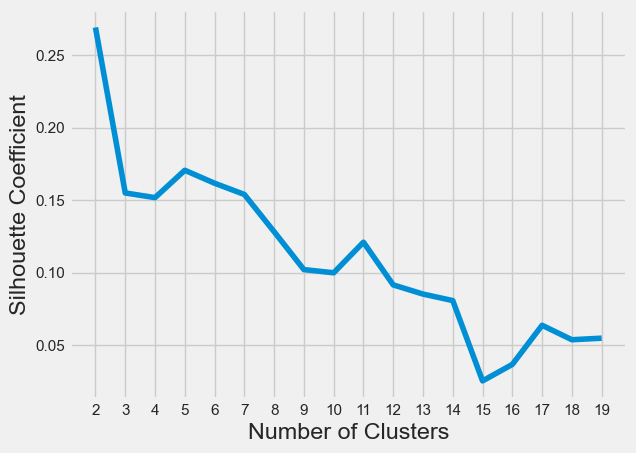

In [16]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 20), silhouette_coefficients)
plt.xticks(range(2, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

# Looking at clusters

In [17]:
def plot_clusters(df,dft,n,var1,var2):
    fig, ax = plt.subplots(1,1, figsize=(6.4,4.8))
    sns.scatterplot(data=df,x= var1, y= var2 , ax= ax)
    sns.scatterplot(data=dft,x= var1, y= var2, ax= ax)
    p = snso.Plot(data=dft, x= var1, y= var2, text="team_name").add(snso.Text(valign="bottom"))
    p.on(ax).show()

## 3 Clusters

In [18]:
n = 3
kmeans = KMeans(
    init="random",
    n_clusters=n,
    n_init=10,
    max_iter=300,
    random_state=42
)
kmeans.fit(scaled_features)
clusters = kmeans.cluster_centers_
clusters = np.round(clusters,3)
dfc = dfs.copy()
for i in range(len(clusters)):
    dfc.loc[f"c{i+1}"] = clusters[i]
dfc["Ball"] = dfc["PRBallHandler"] + dfc["Isolation"]
dfc["Shoot"] = dfc["Spotup"] + dfc["OffScreen"] + dfc["Handoff"]
dfc["Big"] = dfc["Cut"] + dfc["PRRollMan"]	+ dfc["Postup"] + dfc["Postup"]
dfct = dfc.tail(n)
dfc = dfc.head(-n)
dfc["label"] = kmeans.labels_
display(dfct)

play_type,PRBallHandler,Isolation,Spotup,OffScreen,Handoff,Cut,PRRollMan,Postup,OffRebound,Transition,Ball,Shoot,Big
team_name,,,,,,,,,,,,,
c1,0.186,0.074,0.239,0.039,0.048,0.059,0.060,0.025,0.047,0.170,0.260,0.326,0.169
c2,0.111,0.054,0.284,0.018,0.025,0.067,0.048,0.041,0.045,0.252,0.165,0.327,0.197
c3,0.155,0.065,0.213,0.038,0.054,0.072,0.060,0.045,0.053,0.186,0.220,0.305,0.222


In [19]:
dfc["label"] = dfc["label"].astype("category")
dfc["label"] = dfc["label"].cat.rename_categories(["wing","ballh","big"])
dfc["label"].value_counts()/len(dfc)

label
big      0.600000
wing     0.333333
ballh    0.066667
Name: count, dtype: float64

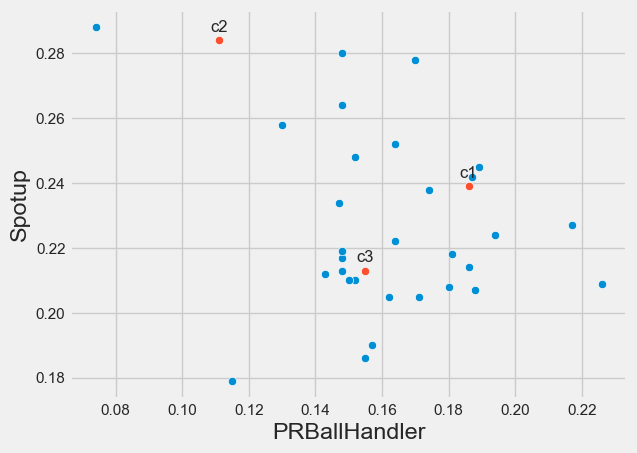

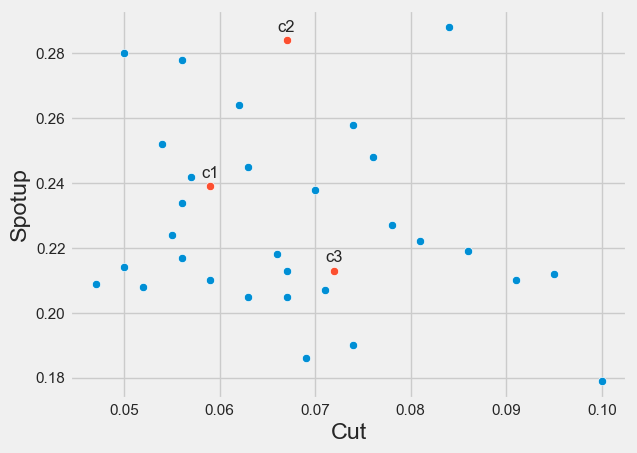

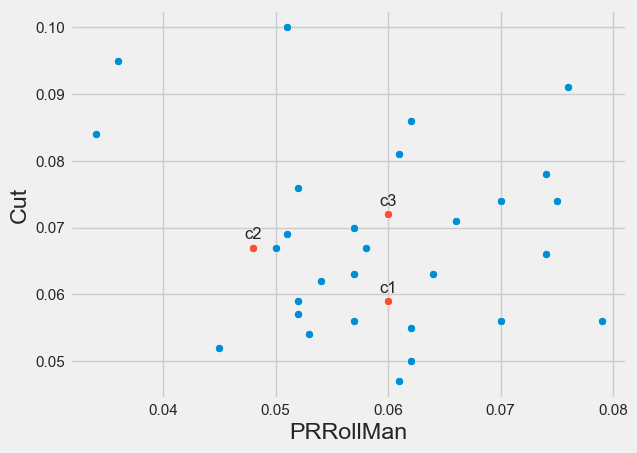

In [20]:
plot_clusters(dfc,dfct,n,"PRBallHandler","Spotup")
plot_clusters(dfc,dfct,n,"Cut","Spotup")
plot_clusters(dfc,dfct,n,"PRRollMan","Cut")

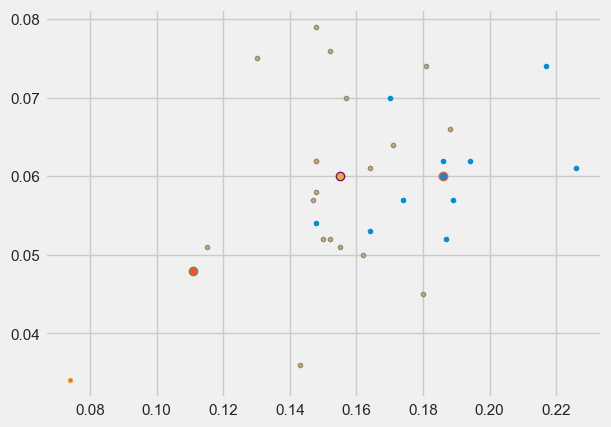

In [21]:
X = scaled_features
k_means_labels = pairwise_distances_argmin(X, clusters)
colors = sns.color_palette(n_colors=n)
fig, ax = plt.subplots(1,1)
var1 = 0
var2 = 6
for k,col in zip(range(n),colors):
    members = k_means_labels == k
    ax.plot(X[members,var1],X[members,var2],'.', markerfacecolor = col)
    ax.plot(clusters[k,var1],clusters[k,var2],"o", markerfacecolor = col)

## 12 Clusters

In [22]:
n = 12
kmeans = KMeans(
    init="random",
    n_clusters=n,
    n_init=10,
    max_iter=300,
    random_state=42
)
kmeans.fit(scaled_features)
clusters = kmeans.cluster_centers_
clusters = np.round(clusters,3)
dfc = dfs.copy()
for i in range(len(clusters)):
    dfc.loc[f"c{i+1}"] = clusters[i]
dfc["Ball"] = dfc["PRBallHandler"] + dfc["Isolation"]
dfc["Shoot"] = dfc["Spotup"] + dfc["OffScreen"] + dfc["Handoff"]
dfc["Big"] = dfc["Cut"] + dfc["PRRollMan"]	+ dfc["Postup"] + dfc["Postup"]
dfct = dfc.tail(n)
dfc = dfc.head(-n)
dfc["label"] = kmeans.labels_
# display(dfct)

In [23]:
dfct.sort_values(by="PRBallHandler")

play_type,PRBallHandler,Isolation,Spotup,OffScreen,Handoff,Cut,PRRollMan,Postup,OffRebound,Transition,Ball,Shoot,Big
team_name,,,,,,,,,,,,,
c12,0.074,0.060,0.288,0.019,0.018,0.084,0.034,0.041,0.051,0.271,0.134,0.325,0.200
c7,0.139,0.037,0.205,0.050,0.061,0.093,0.056,0.037,0.062,0.200,0.176,0.316,0.223
c8,0.139,0.066,0.261,0.030,0.070,0.068,0.064,0.030,0.044,0.168,0.205,0.361,0.192
c11,0.148,0.048,0.280,0.018,0.032,0.050,0.062,0.041,0.039,0.234,0.196,0.330,0.194
c2,0.153,0.095,0.224,0.035,0.042,0.064,0.053,0.048,0.047,0.186,0.248,0.301,0.213
c5,0.155,0.061,0.186,0.072,0.076,0.069,0.051,0.032,0.063,0.161,0.216,0.334,0.184
c10,0.156,0.073,0.206,0.027,0.060,0.065,0.068,0.061,0.050,0.182,0.229,0.293,0.255
c1,0.167,0.072,0.265,0.055,0.040,0.055,0.062,0.034,0.042,0.156,0.239,0.360,0.185
c6,0.176,0.064,0.227,0.038,0.051,0.065,0.054,0.033,0.055,0.177,0.240,0.316,0.185


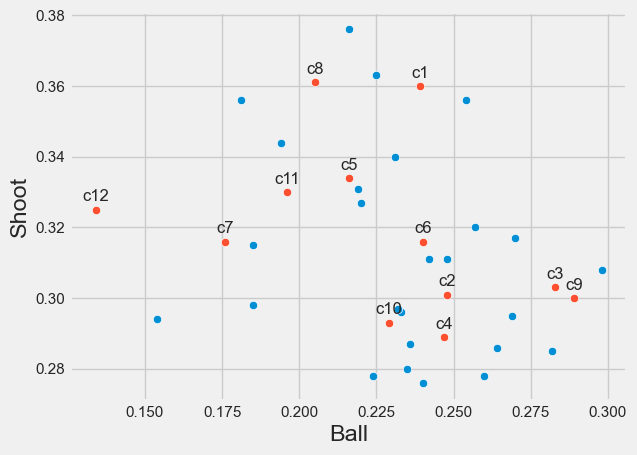

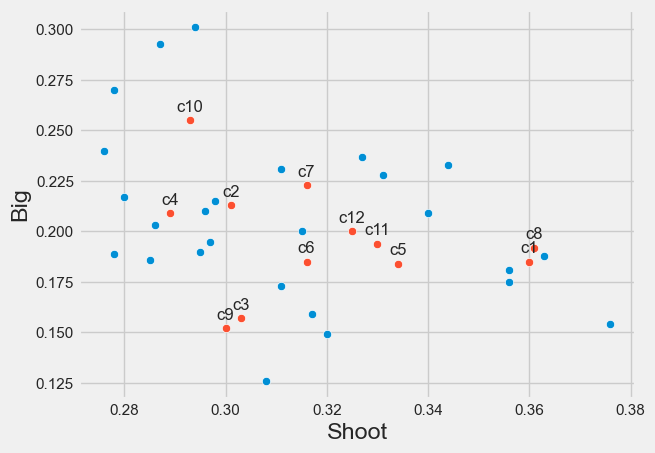

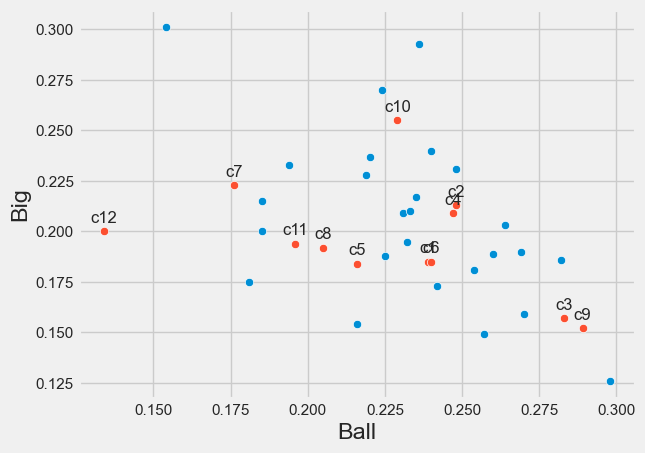

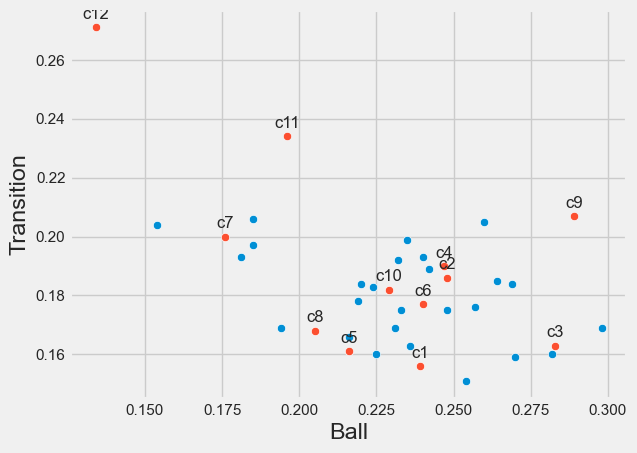

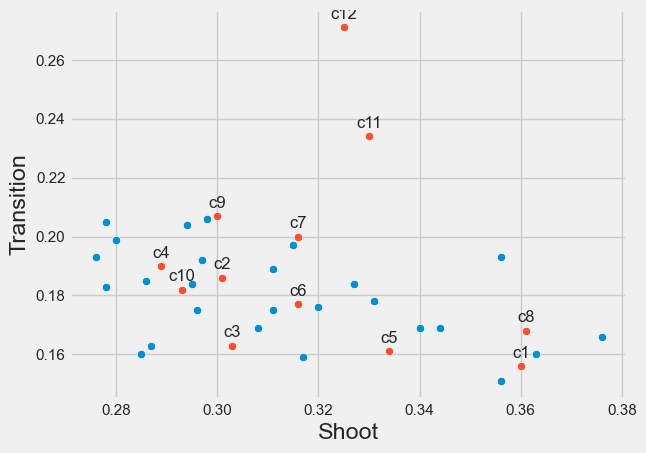

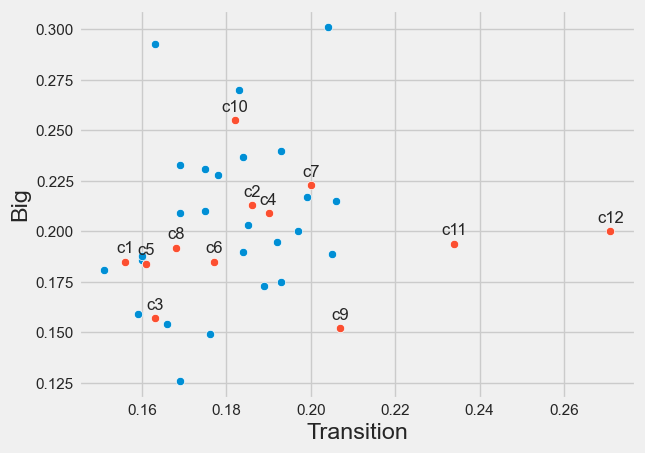

In [24]:
plot_clusters(dfc,dfct,n,"Ball","Shoot")
plot_clusters(dfc,dfct,n,"Shoot","Big")
plot_clusters(dfc,dfct,n,"Ball","Big")
plot_clusters(dfc,dfct,n,"Ball","Transition")
plot_clusters(dfc,dfct,n,"Shoot","Transition")
plot_clusters(dfc,dfct,n,"Transition","Big")